# Exponential fits on coupled calorimetry and rheometry data

_Produces Figure 7_

### Import packages

In [5]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.ticker import ScalarFormatter # for scalars in semilogy labels
from matplotlib.ticker import FormatStrFormatter
from matplotlib.patches import ConnectionPatch
from scipy.optimize import curve_fit

import numpy as np
from pranzo import Analyzer
from bamboost import Manager

import colors as c
from utilities import set_plot_theme, find_closest_index
set_plot_theme()

### Specify the path to the database

The database can be downloaded from the [ETH Research Collection](https://www.research-collection.ethz.ch/)

In [6]:
database_path = ('../out')

db = Manager(database_path)

### Plot data and fit exponentials

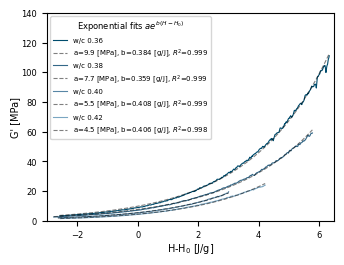

In [7]:
# figure design
fig_exponent, ax_exp = plt.subplots(figsize=(90/25.4, 70/25.4)) # in mm

# read the data
exps = [
    db['opc36'], db['opc38'],
    db['opc40'], db['opc42'],
]

# set w/c ratios, onset times and colors
wcs = ['0.36', '0.38', '0.40', '0.42']
onset_times = [8000, 8400, 8700, 8900]
colors = [c.blue34, c.blue36, c.blue38, c.blue40, c.blue42]

# fitting setup
fit_params = []
def expfit(x, a, b):
    return a*np.exp(b*x)

# loop over data
for i in range(len(exps)):
    exp = exps[i]
    a = Analyzer(exp)
    
    # markers design
    x_fntsz=4.5
    x_color = '0.1'

    # data for time evolutions
    calo = a.calo
    rheo = a.rheo

    t = np.linspace(0, 4*3500, 20000)
    if i == 2:
        t = np.linspace(0, 4*3500, 20000)
    h = calo.interpolate('norm_heat_flow_Wpgbinder', t) 
    H = calo.interpolate('norm_heat_Jpgbinder', t)
    G = rheo.interpolate('storage_modulus_Pa', t, cutoff=0.012)

    idx_calonoise = find_closest_index(t, 3800)
    idx_bump = find_closest_index(t, onset_times[i])

    # plot H-H0 - t with markers
    DH_dashed = H[:idx_calonoise] - H[idx_bump]
    DH_full = H[idx_calonoise:] - H[idx_bump]

    # plot G-DH and Gtilde-DH with markers
    rheo = a.rheo.phase('p2')
    calo = a.calo

    mytime = np.linspace(3800, 3.85*3600, 20000)
    G = rheo.interpolate('storage_modulus_Pa', mytime, cutoff=0.012)
    H = calo.interpolate('norm_heat_Jpgbinder', mytime)
    idx_bump = find_closest_index(mytime, onset_times[i])
    DH = H - H [idx_bump]
    Gtilde = G/G[idx_bump]

    a.myplot(ax=ax_exp, x=DH*a.nfH, y=G*a.nfG, 
             c=colors[i], xlbl='', ylbl='',
             label=f"w/c {wcs[i]}")
    
    # find indices where neither DH nor G are NaN
    valid_indices = ~np.isnan(DH) & ~np.isnan(G)

    # filter NaN values from both arrays
    DH = DH[valid_indices]
    G = G[valid_indices]
    
    # add straight lines with slope in insets
    p, pc = curve_fit(expfit, DH, G)
    
    # calculate R^2
    G_pred = expfit(DH, *p)
    ss_res = np.sum((G - G_pred) ** 2)
    ss_tot = np.sum((G - np.mean(G)) ** 2)
    r_squared = 1 - (ss_res / ss_tot)

    fit_params.append(p)

    # plot exponential fits
    ax_exp.plot(DH*a.nfH, expfit(DH, *p)*a.nfG, 
                '--', c='k', alpha=0.5,
                label=f"a={p[0]*a.nfG:.1f} [MPa], b={p[1]:.3f} [g/J], $R^2$={r_squared:.3f}")


# set axis labels
ax_exp.set_xlabel(r"H-H$_\mathrm{0}$ [J/g]")
ax_exp.set_ylabel(r"G' [MPa]")

# set axis limits
DH_xmin, DH_xmax = -3, 6.5
ax_exp.set_xlim(DH_xmin, DH_xmax)
ax_exp.set_ylim(0, 140)

# add legend
ax_exp.legend(title=r'Exponential fits $ae^{b(H-H_0)}$',
              ncol=1)

# display figure
plt.tight_layout()
plt.show()

### Compute mean and standard deviation

In [8]:
import statistics

# loop over fitting parameters
data = []
for p in fit_params:
    data.append(p[1])

# calculate mean
mean_value = statistics.mean(data)

# calculate standard deviation
std_dev = statistics.stdev(data)

# print average and standard deviation of fits
print(data)
print(f"Average: {mean_value:.2f}")
print(f"Standard deviation: {std_dev:.2f}")

[np.float64(0.38444711170962875), np.float64(0.35908535855756996), np.float64(0.4081030157366626), np.float64(0.40632228925115993)]
Average: 0.39
Standard deviation: 0.02
